## Red neuronal de tres capas en Pytorch

Los números utilizados para ejercicio se pueden descargar de:
http://yann.lecun.com/exdb/mnist/

Los archivos descomprimidos deberán de colocarse en la carpeta /mnist/

In [59]:
import numpy as np
import importlib

In [60]:
import torch
from torch.autograd import Variable
from time import time
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, TensorDataset
import torchvision
from torchvision import datasets, transforms
device = torch.device('cpu')

In [61]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [62]:
from ipywidgets import interact, interact_manual, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

# Datos

Los datos a utilizar son imágenes de dígitos.  En su formato original, se leen dos vectores:
* Los datos de **entrada** vienen en un vector 3D.
  * Cada renglón corresponde a un ejemplar de entrenamiento.
  * En cada renglón hay una matriz 2D con las intensidades de los pixels.
* Las etiquetas (dígito correcto que representan) vienen en un vector de una dimensión.

In [63]:
from mnist.read import read, printFull

filesDir = './mnist/'
trainingSetFile = filesDir + 'train-images.idx3-ubyte'
trainingSetLabelsFile = filesDir + 'train-labels.idx1-ubyte'
testSetFile = filesDir + 't10k-images.idx3-ubyte'
testSetLabelsFile = filesDir + 't10k-labels.idx1-ubyte'


###     /\ |__   __||  ____|| \ | | / ____||_   _|/ __ \ | \ | |
###    /  \   | |   | |__   |  \| || |       | | | |  | ||  \| |
###   / /\ \  | |   |  __|  | . ` || |       | | | |  | || . ` |
###  / ____ \ | |   | |____ | |\  || |____  _| |_| |__| || |\  |
### /_/    \_\|_|   |______||_| \_| \_____||_____|\____/ |_| \_|
### EN LAS SIQUIENTES DOS LINEAS SE LIMITA EL TAMAÑO DE LOS DATOS DE ENTRENAMIENTO,EN CASO
### DE INCREMENTAR LA CANTIDAD EL CALCULO TOMA DRASTICAMENTE MAS TIEMPO EN EL CASO DE APROXIMACION DEL GRADIENTE,SE INCLUYE
### IMPRESION DEL PROGRESO DEL METODO



trainData = read(fileName=trainingSetFile).astype(np.float64)
trainDataLabels = read(fileName=trainingSetLabelsFile).astype(np.float64)

testData = read(fileName=testSetFile).astype(np.float64)
testDataLabels = read(fileName=testSetLabelsFile).astype(np.float64)

Vector de  3  dimensiones:  (60000, 28, 28)  tipo  <class 'numpy.uint8'>
Vector de  1  dimensiones:  (60000,)  tipo  <class 'numpy.uint8'>
Vector de  3  dimensiones:  (10000, 28, 28)  tipo  <class 'numpy.uint8'>
Vector de  1  dimensiones:  (10000,)  tipo  <class 'numpy.uint8'>


In [64]:
import mnist.plot
from mnist.plot import muestraImagen

In [65]:
@interact(
    indice = (0, len(trainData) - 1)
)
def muestraImagenEntrenamiento(indice):
    muestraImagen(trainData, trainDataLabels, indice)

interactive(children=(IntSlider(value=29999, description='indice', max=59999), Output()), _dom_classes=('widge…

Para poder trabajar con la red neuronal, necesitaremos transformar esas entradas, de modo que los valores de las intensidades de los pixeles se encuentren en un solo renglón.  Las entradas a la red neuronal, deberán ser de la forma:
\begin{align}
  X &= \begin{bmatrix}
       x_1^{(1)} ... x_n^{(1)}  \\
       x_1^{(2)} ... x_n^{(2)}  \\
       ...\\
       x_1^{(m)} ... x_n^{(m)}
      \end{bmatrix}
\end{align}
También necesitaremos que las etiquetas formen una matriz donde la única columna distinta de cero, sea la correspondiente al dígito correcto:
\begin{align}
  Y &= \begin{bmatrix}
       0, ..., y_{label_0} = 1 , ... ,0 \\
       ... \\
       0, ..., y_{label_n} = 1 , ... ,0 \\
      \end{bmatrix}
\end{align}


In [66]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.FloatTensor([x_tensor])
        self.y = torch.FloatTensor([y_tensor])
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [67]:
## Define las matrices X y Y, como se muestra arriba
## A partir de trainData y trainDataLabels
## TIP: usar reshape
def makeX(file_set):
    data = read(file_set).astype(np.float64)
    data = np.reshape(data,(len(data),-1)) #flattening image into vector
    data = (data - data.mean())/data.std() #normalizing data
    return data

def makeY(file_labels):
    data = read(file_labels).astype(np.float64)
    return data

x_train_numpy = makeX("mnist/train-images.idx3-ubyte")
y_train_numpy = makeY("mnist/train-labels.idx1-ubyte")

x_train_tensor = torch.FloatTensor(x_train_numpy)
y_train_tensor = torch.FloatTensor(y_train_numpy)

#train_data = CustomDataset(x_train_tensor, y_train_tensor)
train_data = utils.TensorDataset(x_train_tensor,y_train_tensor)
XY_Train = utils.DataLoader(train_data, batch_size=128, shuffle=False) # create your dataloader

#for i,batch in enumerate(XY_Train):
#    print(i,batch)

Vector de  3  dimensiones:  (60000, 28, 28)  tipo  <class 'numpy.uint8'>
Vector de  1  dimensiones:  (60000,)  tipo  <class 'numpy.uint8'>


In [68]:
## Repite lo mismo con los datos de entrenamiento
XTest = makeX("mnist/t10k-images.idx3-ubyte")
YTest = makeY("mnist/t10k-labels.idx1-ubyte")

Vector de  3  dimensiones:  (10000, 28, 28)  tipo  <class 'numpy.uint8'>
Vector de  1  dimensiones:  (10000,)  tipo  <class 'numpy.uint8'>


## Red con tres capas
La red neuronal que se utilizará es una red neuronal de tres capas:
* Entrada
* Oculta
* Salida
La forma genérica de la red se ilustra a continuación.  Sólo que la red de este ejercicio tendrá más neuronas en cada capa.
<img src="figuras/Red3Capas.png"/>
Para este ejercicio el número de neuronas será:
* 785 + 1 (28x28 pixeles más la unidad de sesgo)
* X + 1 unidades en la capa oculta donde X es elección del diseñador
* 10 neuronas de salida (una por cada dígito)
Por lo tanto, las dimensiones de las matrices de pesos son:
* $\Theta^{(0)} \rightarrow (25 \times 786)$
* $\Theta^{(1)} \rightarrow (10 \times 26)$

In [69]:
## Programa una clase RedNeuronal en PyTorch con la arquitectura anterior.

class NN:
    def __init__(self,input_size,hidden,output_size):
        self.model = nn.Sequential(
            nn.Linear(input_size,hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden,output_size),
            nn.Softmax(dim=1),
            nn.BatchNorm1d(output_size)
          ).to(device)
        self.losses = []
        
    def feedForward(self,X):
        return self.model(X)
    
    def backPropagate(self,X,Y):
        self.loss = nn.CrossEntropyLoss()
        out = self.feedForward(X)
        error = self.loss(out,Y)
        error.backward()
        return error
        
    def train(self,XY_DataLoader,NofE=100):
        self.optimizer = optim.AdamW(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
        self.optimizer = optim.Adagrad(self.model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
        self.loss = nn.CrossEntropyLoss()
        for epoch in tqdm(range(NofE)):
            for x_batch, y_batch in XY_DataLoader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                self.train_step(x_batch,y_batch)
                #print(len(x_batch))
    
    def train_step(self,x,y):
         # Sets model to TRAIN mode
        self.model.train()
        # Makes predictions
        yhat = self.model(x)
        # Computes loss
        loss = self.loss(yhat,y.long())
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()
        # saves the loss
        self.losses.append(loss.item())
                
    def test(self,test_X,test_Y):
        tensor_X = Variable(torch.FloatTensor(test_X),requires_grad = True).to(device)
        tensor_Y = Variable(torch.LongTensor(test_Y),requires_grad = False).to(device)
        out = self.feedForward(tensor_X)
        accT = out.argmax(dim=1)==tensor_Y
        accT = torch.sum(accT)
        acc = accT.data.numpy()/test_X.shape[0]
        print("Acc:",acc*100,"%")
        return acc

In [ ]:
## Entrena la red neuronal implementada en la celda anterior y grafica el error
mnist_nn = NN(784,26,10)
mnist_nn.train(XY_Train,100)
mnist_nn.test(XTest,YTest)


 69%|██████▉   | 69/100 [01:22<00:38,  1.25s/it]

In [57]:
## Prueba el modelo entrenado con los datos de prueba y muestra la métrica de exatitud

interactive(children=(IntSlider(value=29999, description='indice', max=59999), Output()), _dom_classes=('widge…

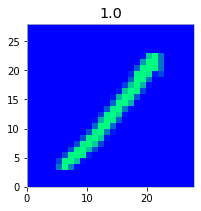

In [58]:
@interact(
    indice = (0, len(trainData) - 1)
)
def muestraImagenEntrenamiento(indice):
    muestraImagen(trainData, trainDataLabels, indice)
    tensor_X = torch.FloatTensor([x_train_tensor[indice].numpy()])
    print("PREDICCIÓN:" + str(mnist_nn.feedForward(tensor_X).argmax(dim=1)))